In [1]:
from model import UNET
import numpy as np
from matplotlib import pyplot as plt
import torch
import os
from PIL import Image

In [2]:
def display_images_in_row(images, figsize=(9, 3)):
    fig, axis = plt.subplots(1, len(images), figsize=figsize)
    for ax, img in zip(axis, images):
        ax.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

def read_images(dir_path):
    images = []
    for image_name in os.listdir(dir_path):
        img_path = os.path.join(dir_path, image_name)
        image = torch.Tensor(np.array((Image.open(img_path).convert("L").resize((960, 960))))).to("cuda")
        image = image.unsqueeze(0)
        images.append(image)
    return images

In [3]:
val_images = read_images("data/val_images")
val_masks = read_images("data/val_masks")
train_images = read_images("data/train_images")
train_masks = read_images("data/train_masks")
test_images = read_images("test/")

In [5]:
model = UNET(in_channels=1, out_channels=1).to("cuda")
model.load_state_dict(torch.load("saved_models/model_unet9.pth.tar"))

<All keys matched successfully>

In [6]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params / 1e6}M")

Number of parameters: 1.093165M


In [ ]:
def test_unet(idx):
    result = model.forward(val_images[idx].unsqueeze(0)).squeeze().squeeze()
    preds = torch.where(torch.sigmoid(result) > 0.5, 1, 0).int().cpu()
    print(f"IoU score: {iou.item():.4f}")
    display_images_in_row((
        val_images[idx].cpu().squeeze(0).detach(),
        preds
    ))

for i in range(20):
    test_unet(i)

c:\Users\Opina\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


IoU score: 0.4542


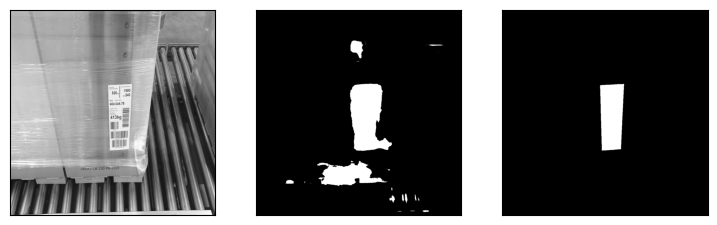

IoU score: 0.6514


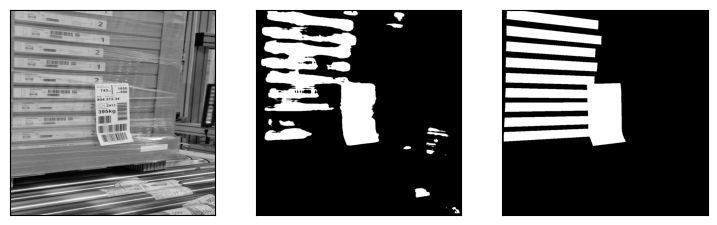

IoU score: 0.3721


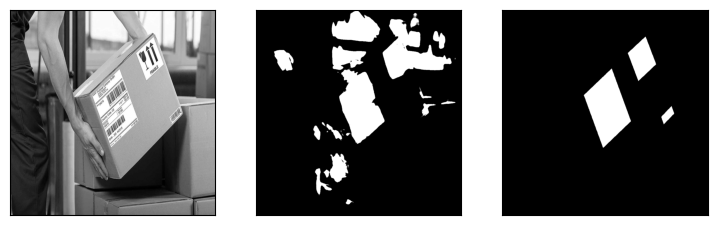

IoU score: 0.8534


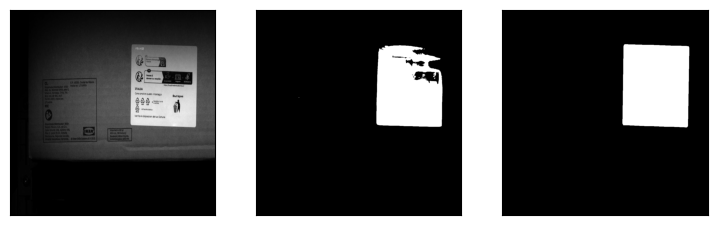

In [7]:
def test_unet(idx):
    result = model.forward(train_images[idx].unsqueeze(0)).squeeze().squeeze()

    preds = torch.where(torch.sigmoid(result) > 0.5, 1, 0).int().cpu()
    masks = train_masks[idx].cpu().squeeze(0).detach().int()
    iou = (preds & masks).sum() / (preds | masks).sum()
    print(f"IoU score: {iou.item():.4f}")
    display_images_in_row((
        train_images[idx].cpu().squeeze(0).detach(),
        preds,
        masks
    ))

test_unet(1)
test_unet(10)
test_unet(16)
test_unet(100)

IoU score: 0.4680


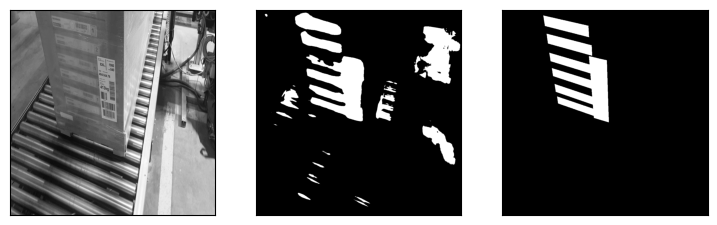

IoU score: 0.4831


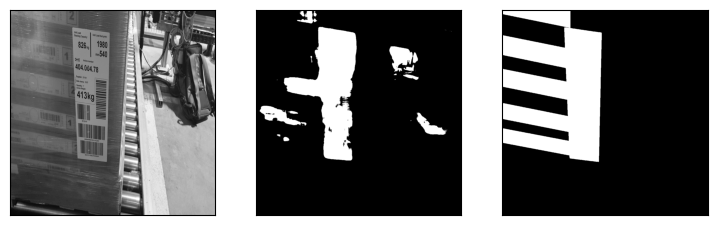

IoU score: 0.3535


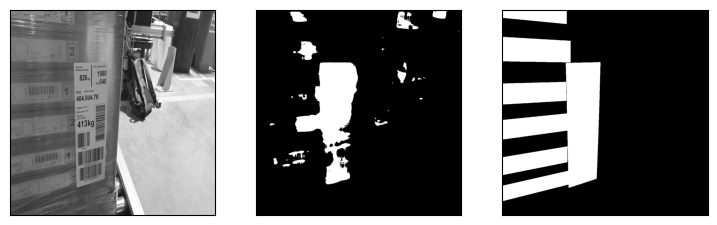

IoU score: 0.6885


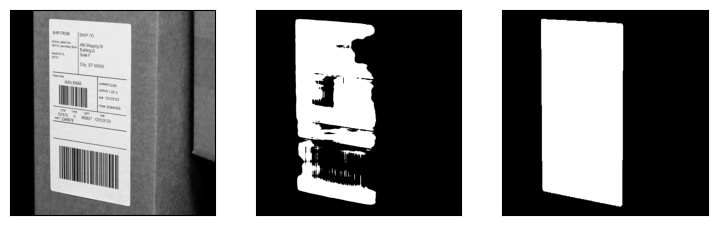

IoU score: 0.6955


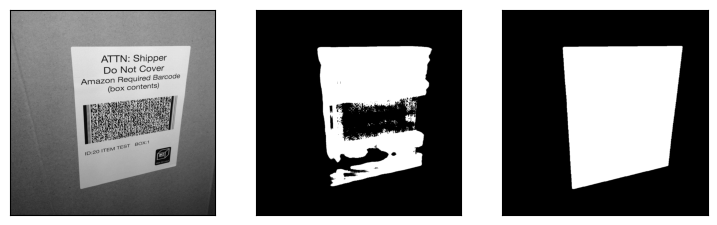

IoU score: 0.7542


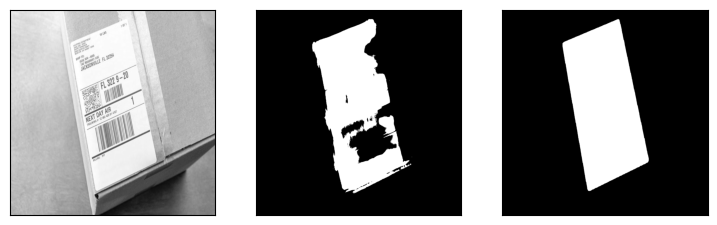

IoU score: 0.8643


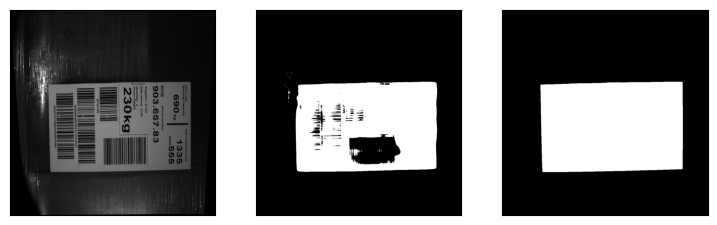

IoU score: 0.9350


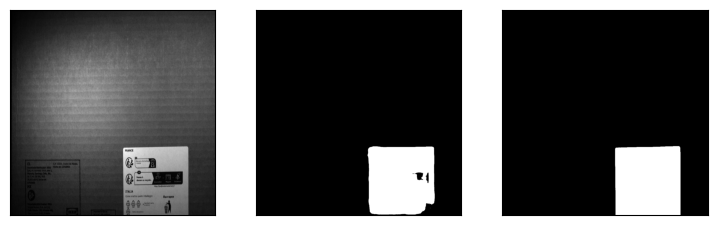

IoU score: 0.7852


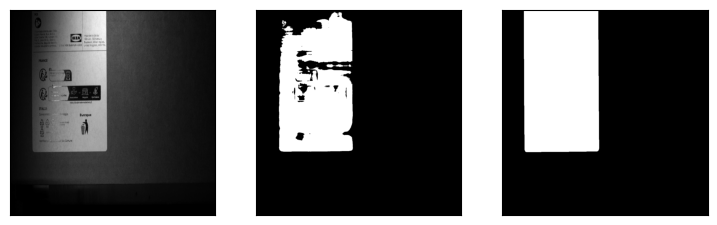

IoU score: 0.6851


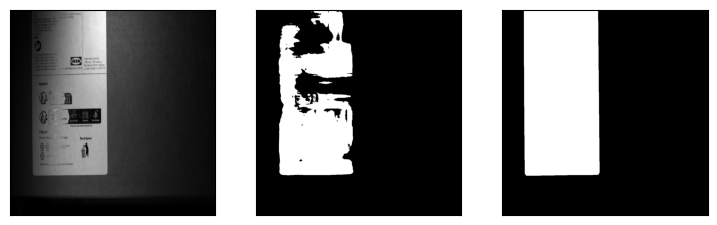

IoU score: 0.8590


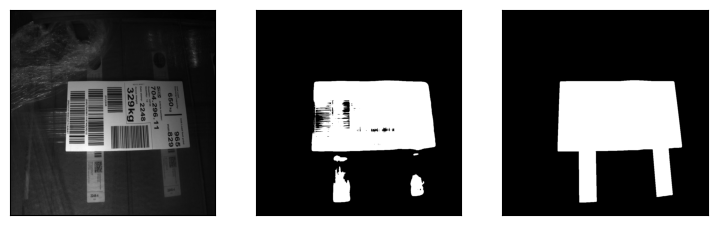

IoU score: 0.8739


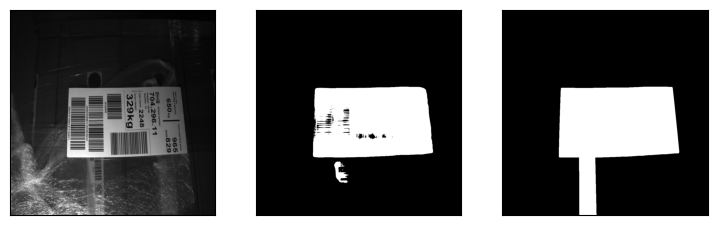

IoU score: 0.9290


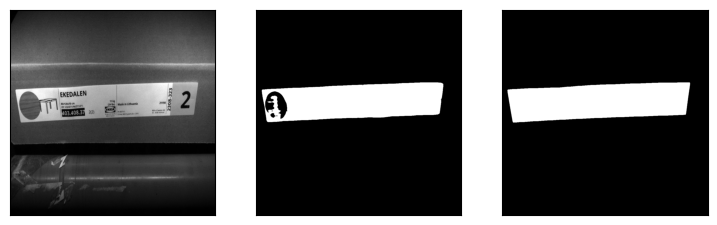

IoU score: 0.9190


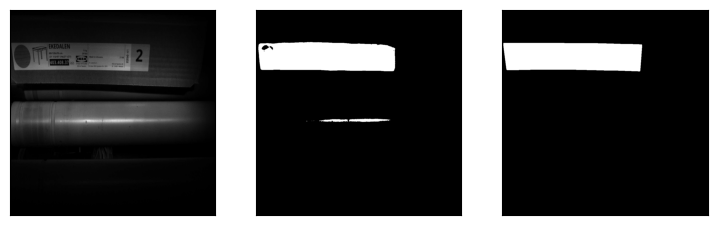

IoU score: 0.8310


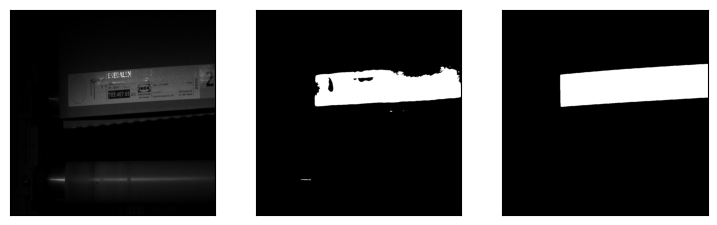

IoU score: 0.7806


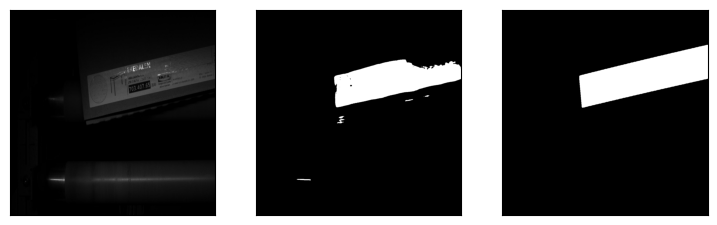

IoU score: 0.9299


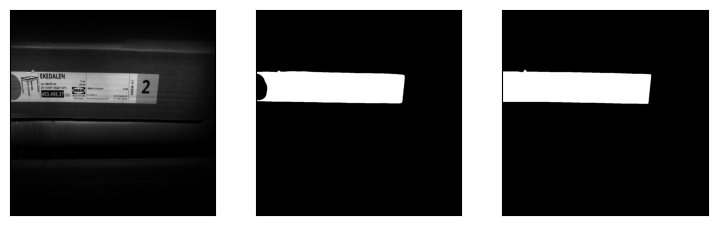

IoU score: 0.9118


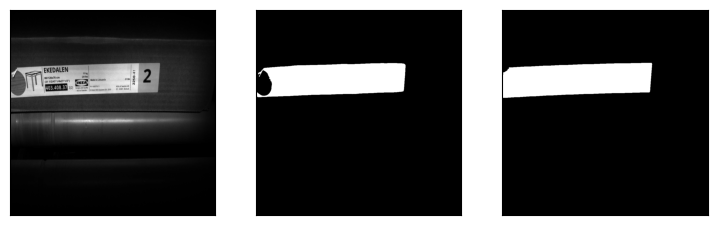

IoU score: 0.8333


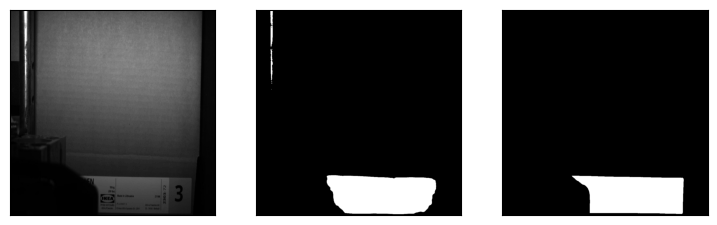

IoU score: 0.8219


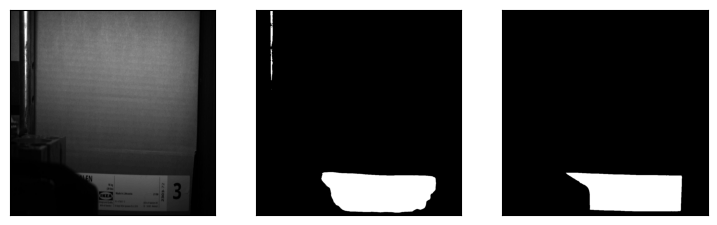

In [8]:
def test_unet(idx):
    result = model.forward(val_images[idx].unsqueeze(0)).squeeze().squeeze()
    preds = torch.where(torch.sigmoid(result) > 0.5, 1, 0).int().cpu()
    masks = val_masks[idx].cpu().squeeze(0).detach().int()
    iou = (preds & masks).sum() / (preds | masks).sum()
    print(f"IoU score: {iou.item():.4f}")
    display_images_in_row((
        val_images[idx].cpu().squeeze(0).detach(),
        preds,
        masks
    ))

for i in range(20):
    test_unet(i)

### Exporting

In [18]:
traced_script_module = torch.jit.trace(model, train_images[0].unsqueeze(0))

In [20]:
model = torch.load("unet_exported.torchscript")
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params / 1e6}M")

Number of parameters: 1.093165M


In [19]:
traced_script_module.save("unet_exported.torchscript")